In [1]:
# MFCC's vector can vary their size acording with the samples duration
# CNN requires a fixed input
# we need put all samples in same saze, acording to biggest sample

import numpy as np
from os import listdir
from os.path import isfile, join
import librosa


# get the max pad length, to make data with the same columns values
def getMaxPad(fulldatasetpath):
    
    print("searching for max pad length...")
        
    max_pad_len = 0
    
    # pick sample files #
    filenames = [f for f in listdir(fulldatasetpath) if isfile(join(fulldatasetpath, f))]
    filenames = sorted(filenames)

    # apply audio descritors to extract audio features 
    for i in range(len(filenames)-1):
        i = i + 1
        
        # pick audio's vector and sample rate
        audio, sample_rate = librosa.load(fulldatasetpath + filenames[i], res_type='kaiser_fast') 
        
        # apply MFCC descriptor
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        
        # pick the biggest sample size
        if (mfcc.shape[1] > max_pad_len):
            max_pad_len = mfcc.shape[1]
            print("got {} for max_pad_len!".format(mfcc.shape[1]+1))
        
    print("max_pad_len is ", max_pad_len + 1, " (FINISHED).")
        
    return max_pad_len + 1
        
    
    
def extract_features(file_name, max_pad_len, countFiles, numberOfFile):
   
    try:
        
        # pick audio's vector and sample rate
        y, sr = librosa.load(file_name, res_type='kaiser_fast') 
        
        # apply MFCC descriptor
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        
        # put all samples in same shape, acording to max_pad_length
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

        progress_percent = ( numberOfFile / countFiles ) * 100
        
        print("Progress: {0:.2f}%".format(progress_percent), end='\r')
        #print("Extracted MFCC from: {}".format(file_name),"\n", end='\r')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs


In [2]:
# Load various imports 
import os
import pandas as pd

num_rows = 40
num_channels = 1

# vector to colect features from audio files
features = []

# path do dataset
fulldatasetpath = './audio_train-test/'

# pick sample files 
filenames = [f for f in listdir(fulldatasetpath) if isfile(join(fulldatasetpath, f))]
filenames = sorted(filenames)

# get the max pad length
#max_pad_len = getMaxPad(fulldatasetpath)
max_pad_len = 174
num_columns = max_pad_len

print("Extracting features...")

# apply audio descritors to extract audio features 
for i in range(len(filenames)):
    
    # make audio dir
    file_name = os.path.join(os.path.abspath(fulldatasetpath),filenames[i])
    
    # pick audio's class
    class_label = filenames[i].split('_')[2].split('.')[0]
    
    # extract audio features
    data = extract_features(file_name, max_pad_len, len(filenames), i+1)

    # add result in features vector
    features.append([data, class_label])

# if you need shuffle the features vector...    
#np.random.shuffle(features)
    
# convert vector of features in data frame
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])
print('Finished feature extraction from ', len(featuresdf), ' files') 

# save features vector in directory
featuresdf.to_pickle('./data_processed/featuresData')  
print('Data saved sucessfull!')

# load data just to show the structure
df = pd.read_pickle('./data_processed/featuresData')
print(df)

Extracting features...
Finished feature extraction from  600  files
Data saved sucessfull!
                                               feature class_label
0    [[-677.2284, -675.868, -604.5181, -508.6319, -...        fear
1    [[-541.3354, -500.66827, -471.35553, -459.4574...       happy
2    [[-692.65314, -644.6554, -568.15466, -515.6153...         sad
3    [[-681.12274, -651.9668, -525.6198, -443.5369,...        fear
4    [[-655.34607, -582.11316, -496.3355, -432.5717...       happy
..                                                 ...         ...
595  [[-700.8672, -633.0773, -548.29913, -492.718, ...       happy
596  [[-550.38446, -509.70435, -474.91278, -453.879...         sad
597  [[-533.8698, -473.1169, -420.50345, -391.5591,...        fear
598  [[-667.7516, -631.7557, -551.61646, -502.2961,...       happy
599  [[-761.32166, -732.29486, -638.62305, -572.652...         sad

[600 rows x 2 columns]



Processing data...



<Figure size 432x288 with 0 Axes>

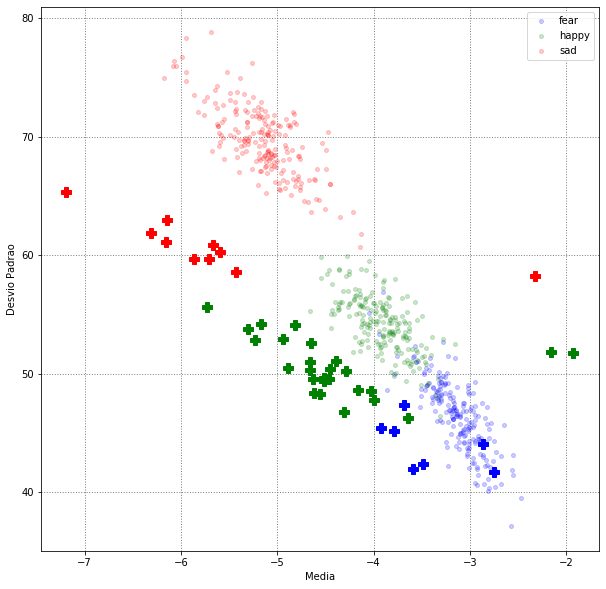

In [4]:
import matplotlib.pyplot as plt
      
# function to normalize the test and the train data
def normalize(x_train, x_test):
    
    x_train_aux = x_train
    x_test_aux = x_test
    
    mu = np.mean(x_train_aux, axis=0)
    std = np.std(x_train_aux, axis=0)
    
    std2 = std
    std2[std2 == 0] = 1
    
    x_train_aux = (x_train_aux - mu) / std2
    x_test_aux = (x_test_aux - mu) / std2
        
    return x_train_aux, x_test_aux  
       

# function to load files in a vector <features, class_label>
def loadFiles (fulldatasetpath):
    
    features = []
    
    filenames = [f for f in listdir(fulldatasetpath) if isfile(join(fulldatasetpath, f))]
    filenames = sorted(filenames)
    
    for i in range(len(filenames)):
        
        file_name = os.path.join(os.path.abspath(fulldatasetpath),filenames[i])
        
        data = extract_features(file_name,max_pad_len,len(filenames),i+1)
        
        class_label = filenames[i].split('_')[2].split('.')[0]
        
        features.append([data, class_label])
        

    return features    
        
    
# split vector in data frame <features, class>
def splitFiles(fulldatasetpath):
    
    features = loadFiles(fulldatasetpath)
    
    dataFrame = pd.DataFrame(features, columns=['feature','class_label'])
    
    x = np.array(dataFrame.feature.tolist())
    y = np.array(dataFrame.class_label.tolist())
    
    return x, y
    

# function to plot a features vector
# x: features
# y: feature's class
# markSize: size of plot's
# form: can be Ball or Triangle
def plotVector(x, y, markSize, form, brightness):
    
    flagSad = 0
    flagFear = 0
    flagHappy = 0
    
    # plot feature by feature
    for i in range(len(x)):
        
        feat_mean = np.mean(x[i])
        feat_std = np.std(x[i])
        
        
        if(form == "ball"):
            form = 'o'
        elif(form == "triangle"):
            form = 'v'
        elif(form == "plus"):
            form = 'P'
            
        emotion = ''
        if(y[i] == 'sad'):    
            emotion = 'r'
        elif(y[i] == 'happy'): 
            emotion = 'g'
        elif(y[i] == 'fear'):
            emotion = 'b'
        
        plt.plot(feat_mean, feat_std, "{}{}".format(emotion,form), label = 'sad', markersize=markSize, alpha=brightness)
          

print("\nProcessing data...\n")
    
plt.figure()
plt.figure(figsize=(10,10))
plt.grid(color='gray', linestyle=':', linewidth=1)    
    
    
# plot train data
x = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())
plotVector(x, y, 4, "ball", 0.2)

# plot validation data
x_valid, y_valid = splitFiles('./audio_valid/')
plotVector(x_valid, y_valid, 10, "plus", 1)

plt.xlabel('Media')
plt.ylabel('Desvio Padrao')
plt.legend(['fear','happy','sad'])
plt.show()


# plot graphic to see data normalized

#x_norm, x_valid_norm = normalize(x, x_valid)

#plt.figure()
#plt.figure(figsize=(10,10))
#plt.grid(color='gray', linestyle=':', linewidth=1)    

#plotVector(x_norm, y, 4, "ball", 0.3)
#plotVector(x_valid_norm, y_valid, 10, "plus", 1)

#plt.xlabel('Media')
#plt.ylabel('Desvio Padrao')
#plt.legend(['fear','happy','sad'])
#plt.show()


## 